<a href="https://colab.research.google.com/github/PavanReddy28/CRuX/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

Naive Bayes algorithms are a set of supervised statistical classification machine learning algorithms based on the Bayes probability theorem.

Bayes theorem states that:

P(A|B) = P(B|A) * P(A)/P(B)

An important assumption made by Bayes theorem is that the value of a particular feature is independent from the value of any other feature for a given the class.


##Basic workflow of building the model:

(From each tweet, build a vocabulary that consists of words, it's sentiment and it's TF-IDF score. For any given string, it's sentiment is decided by multiplying the probability of each word occuring, using Bayes theorem.)

Step 1: Calculate the prior probability for each class labels

Step 2: Find likelihood probability with each attribute for each class

Step 3: Put these value in Bayes Formula and calculate posterior probability

Step 4: See which class has a higher probability, given the input belongs to the higher probability class.

## Packages

In [1]:
import nltk

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [174]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import torch
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import safe_sparse_dot
from tqdm.notebook import tqdm


import re
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

## Importing data

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Sentiment140 Dataset

Using the dataset **Sentiment140** contatining **1,600,000** tweets extracted using twitter api. 
<br>The tweets are annoted as '0 : Negative', '2 : Neutral' and '4 : Positive'.
<br>I have only used the positive and negative tweets to train my model.

In [5]:
twitter_dataset = pd.read_csv('/gdrive/My Drive/Inductions/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=["sentiment", "ids", "date", "flag", "user", "text"])

In [6]:
twitter_dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
twitter_dataset['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

## Data Preprocessing

In [139]:
sentiment, text = twitter_dataset['sentiment'], twitter_dataset['text']

### **Sentiment**

Replacing 4's to 1's (Representation of Positive Data).

In [140]:
sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [141]:
sentiment = sentiment.replace(4,1)

In [142]:
sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

### **Text**

Preprocessing of text data include:
<ol type = "1">
<li>Converting all the data to **Lower Case**</li>
         <li>Replaceing **User ID's** ("@colab", etc.) with "USER"</li>
         <li>Replacing **Emojis** to text representation (According to Emoji Dictionary).</li>
         <li>Replacing **URLs** (starting with "http", "www", etc.) with "URL"</li>
         <li>Removing **Non-Alphabets**</li>
         <li>**Tokenization** : Splitting of the tweets to, list of words.</li>
         <li>**Lemmetization** : Grouping together the different forms of a work so that they can be analyzed as a single word. Done using NLTK Library.
</li>
<li>Removing letters repeated more than 3 times.</li>

In [143]:
#Emojis taken from the internet.

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [144]:
def data_preprocess(textdata):

  lemmatizer = WordNetLemmatizer()

  Processed =[]

  urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  userPattern = '@[^\s]+'
  alphaPattern = r"[^\w]"
  sequenceFind = r"(.)\1\1+"
  sequenceReplace = r"\1\1"

  for tweet in textdata:

    tweet = tweet.lower()

    tweet = re.sub(urlPattern, 'URL ', tweet)
    tweet = re.sub(userPattern, 'USER ', tweet)
    tweet = re.sub(alphaPattern, ' ', tweet)
    tweet = re.sub(sequenceFind, sequenceReplace, tweet)

    for emoji in emojis.keys():
      tweet = tweet.replace(emoji, "EMOJI"+emojis[emoji])

    tweetWords = ''
    for text in tweet.split():
      if len(text)>1:
        text = lemmatizer.lemmatize(text)
        tweetWords += (text +' ')
    
    Processed.append(tweetWords)

  return Processed


In [145]:
%%time
text = data_preprocess(text)
print('Data Processed.')

Data Processed.
CPU times: user 2min 6s, sys: 0 ns, total: 2min 6s
Wall time: 2min 7s


### Train Test Split

In [146]:
X_train, X_test, Y_train, Y_test = train_test_split(text, sentiment, train_size = 0.001,test_size=0.0001, random_state=0)

In [147]:
X_test[:10]

['want to compete want hard competition want to rally want to feel the power coming out of the engine want to compete ',
 'it seems we are stuck on the ground in amarillo they have put ground stop for all flight leaving for denver said update in an hour ',
 'where the are my pinking shear rarararrarararr babyproofing while cutting stuff make me stick shear random place amp forget them ',
 '0ff t0 the meetin hate when ppl v0lunteer my free time grr ',
 'reply me pls ',
 'USER jazz in india is just honda strategy to prove they can make affordable car for the working class it still doesn fit me ',
 'aah met boy he seems nice im happy now ',
 'USER URL sport center you guy are too legit to quit wooww ',
 'USER not bad bit grumpy cause of exam but generally ok ta ',
 'USER can watch it what is it ']

### **TF-IDF Vectorizer**

The <b>'tfidfVectorizer()'</b> method from the sklearn.feature_extraction package, helps convert a collection of raw documents to a matrix of TF-IDF features.

It returns a list of features (here, words are the features) and their respective TF-IDF (Text Frequency - Inverse Document Frequency) scores.
<br>

--------------------------------

**Example**:
<br>
INPUT: corpus = ['This is the first document.','This document is the second document.','And this is the third one.','Is this the first document?',]
<br><br>When the above list is passed through the vectorizer the below list is returned.
<br><br>OUTPUT: ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

-------------------------------------
Setting the Parameters in TF-IDF Vectorizer:
<ol>
<li>Here, I have set <b>n-gram range</b> to (1,2), so that a max of two words can be taken as key words at once (for example: "Very Delicious" will give three features "Very", "Delicious" and "Very Delicious").</li>
<li>Also I set the number of <b>max_features</b> to 100000, so that only the words with hgher scores  are included in the future analysis.</li>
</ol>

In [148]:
Vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, max_features=1000, stop_words=list(stopwords.words('english')))

In [149]:
Vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [150]:
X_train = Vectorizer.transform(X_train)
#X_test = Vectorizer.transform(X_test)

In [151]:
X_train[:10]

<10x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [152]:
#Example using the 1st tweet
df = pd.DataFrame(X_train[0].T.todense(), index=Vectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(50))

               TF-IDF
busy         0.656481
busy busy    0.393284
mm           0.355838
study        0.355838
home         0.263740
work         0.221592
good         0.206051
saw          0.000000
say          0.000000
second       0.000000
save         0.000000
sat          0.000000
school       0.000000
said         0.000000
sad          0.000000
season       0.000000
running      0.000000
saying       0.000000
see user     0.000000
see          0.000000
seeing       0.000000
seem         0.000000
seems        0.000000
seen         0.000000
send         0.000000
serious      0.000000
seriously    0.000000
server       0.000000
service      0.000000
set          0.000000
share        0.000000
shirt        0.000000
shit         0.000000
shopping     0.000000
run          0.000000
10           0.000000
round        0.000000
really want  0.000000
quite        0.000000
quot         0.000000
quot quot    0.000000
radio        0.000000
rain         0.000000
raining      0.000000
random    

## Model

### Naive Bayes

<b>Fit Method</b>
<br>
Here TFIDF represents the Text Frequency Inverse Document Frequency Score.
<br>
<br>
$$parameters(pos) =P(W|pos) = \frac{TFIDF(W)_{pos} + \alpha}{\sum{TFIDF_{pos}} + \alpha*V }\tag{2} $$
<br>
$$parameters(neg)=P(W|neg) = \frac{TFIDF(W)_{neg} + \alpha}{\sum{TFIDF_{neg}} + \alpha*V} $$

<br><br>

<b>Predict Method</b>:
$$P(pos|(w1,w2....wn)) = P(pos)*\prod_{i=1}^{n}P(w_{i}|pos)\tag{1} $$
<br>
$$P(neg|(w1,w2....wn)) = P(neg)*\prod_{i=1}^{n}P(w_{i}|neg) 
$$


In [153]:
class NaiveBayesAlgo:

  def __init__(self, alpha=1):
    self.vocab={}
    self.prob_pos_words = {}
    self.prob_neg_words = {}  
    self.pos_score = 0
    self.neg_score = 0
    self.pos_prior = 0
    self.neg_prior = 0
    self.alpha = alpha

  def vocab_create(self, df, boolVal, li):
  
    for word in li:
      if df.loc[word][0]>0:
        if word in list(self.vocab.keys()):
          if boolVal in list(self.vocab[word].keys()):
            self.vocab[word][boolVal] += df.loc[word][0]
          else:
            self.vocab[word][boolVal] = df.loc[word][0]
        if word not in list(self.vocab.keys()):
          self.vocab[word] = {boolVal : df.loc[word][0]}
        
        if boolVal==1 :
          self.pos_score += self.vocab[word][boolVal]
        else:
          self.neg_score += self.vocab[word][boolVal]
        

  def fit(self, X, Y, Vectorizer, initialize=False):

    if initialize:
      self.vocab = {}
      self.prob_pos_words = {}
      self.prob_neg_words = {}
      self.pos_score = 0
      self.neg_score = 0
      self.pos_prior = 0
      self.neg_prior = 0

    for i in tqdm(range(X.shape[0])):
      df = pd.DataFrame(X[i].T.todense(), index = Vectorizer.get_feature_names(), columns=['TF-IDF'])
      df = df.sort_values('TF-IDF', ascending=False)
      #self.vocab_create(df, Y[i], list(Vectorizer.get_feature_names()))  
      li = Vectorizer.get_feature_names()
      boolVal = Y[i]
      for word in li:
        #print(df.loc[word][0])
        if df.loc[word][0]>0:
          if word in list(self.vocab.keys()):
            if boolVal in list(self.vocab[word].keys()):
              self.vocab[word][boolVal] += df.loc[word][0]
            else:
              self.vocab[word][boolVal] = df.loc[word][0]
          if word not in list(self.vocab.keys()):
            self.vocab[word] = {boolVal : df.loc[word][0]}
          
          if boolVal==1 :
            self.pos_score += self.vocab[word][boolVal]
          else:
            self.neg_score += self.vocab[word][boolVal]

    #print(list(self.vocab.keys()))
    
    for word in tqdm(list(self.vocab.keys())):
      if 1 in list(self.vocab[word].keys()):
        self.prob_pos_words[word] = (self.vocab[word][1] + self.alpha) / (self.pos_score + (self.alpha * len(Vectorizer.get_feature_names())))
        #print(word, self.prob_pos_words[word], 'pos')
      else:
        self.prob_pos_words[word] = 0
      if 0 in list(self.vocab[word].keys()):
        self.prob_neg_words[word] = (self.vocab[word][0] + self.alpha) / (self.neg_score + (self.alpha * len(Vectorizer.get_feature_names())))
        #print(word, self.prob_neg_words[word], 'neg')
      else:
        self.prob_neg_words[word] = 0
      
    pos_labels = list(Y).count(1)
    neg_labels = list(Y).count(0)

    self.pos_prior = pos_labels / len(list(Y))
    self.neg_prior = neg_labels / len(list(Y))

  def predict(self, X):
    '''
    Input a csr_matrix containing preprocessed tweets.
    '''
    pos_prob = self.pos_prior
    neg_prob = self.neg_prior
    y_true=[]
    for i in range(len(X)):
      for word in X[i].split():
        #print(word, i)
        if word in list(self.prob_pos_words.keys()) and self.prob_pos_words[word]>0:
          pos_prob *= self.prob_pos_words[word]
          #print(1)
        else:
          pos_prob *= self.alpha / (self.alpha * len(self.vocab))
        
        if word in list(self.prob_neg_words.keys()) and self.prob_neg_words[word]>0:
          neg_prob *= self.prob_neg_words[word]
        else:
          neg_prob *= self.alpha / (self.alpha * len(self.vocab))
        
      if pos_prob >= neg_prob:
        y_true.append(1)
      else:
        y_true.append(0)
      #print(pos_prob, neg_prob)
    return y_true

  
  def evaluate(self, x_test, y_test):
    
    y_pred = self.predict(x_test)
    print(classification_report(y_test, y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Training

In [154]:
NB = NaiveBayesAlgo()

In [155]:
%%time
NB.fit(X_train, list(Y_train), Vectorizer, initialize=True)


CPU times: user 2min 56s, sys: 1.06 s, total: 2min 57s
Wall time: 2min 59s


### Saving Models

In [167]:
file = open('/gdrive/My Drive/Inductions/vectorizer-ngram_1-2.pickle','wb')
pickle.dump(Vectorizer, file)
file.close()

file = open('/gdrive/My Drive/Inductions/Sentiment-BNB.pickle','wb')
pickle.dump(NB, file)
file.close()

## Evaluation

              precision    recall  f1-score   support

           0       0.80      0.05      0.10        76
           1       0.54      0.99      0.69        84

    accuracy                           0.54       160
   macro avg       0.67      0.52      0.40       160
weighted avg       0.66      0.54      0.41       160



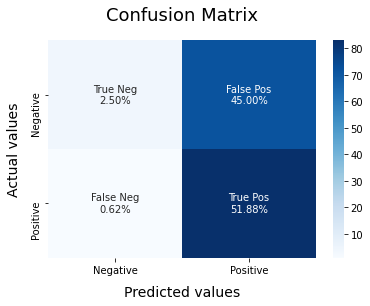

In [173]:
NB.evaluate(X_test, list(Y_test))

In [176]:
Y_pred = NaiveBayes.predict(X_test)
print('Naive Bayes Accuracy =', accuracy_score(y_pred=Y_pred, y_true=Y_test))

Naive Bayes Accuracy = 0.54375


The accuracy that we get is around 55%, which is good, since it's a basic model and also, we are not considering the semantic relation between the words.

## Prediction

### Load Models

In [168]:
file = open('/gdrive/My Drive/Inductions/vectorizer-ngram_1-2.pickle', 'rb')
Vectorizer = pickle.load(file)
file.close()

file = open('/gdrive/My Drive/Inductions/Sentiment-BNB.pickle', 'rb')
NaiveBayes = pickle.load(file)
file.close()

### Predict

In [171]:
text = ['want to compete want hard competition want to rally want to feel the power coming out of the engine want to compete ',
 'it seems we are stuck on the ground in amarillo they have put ground stop for all flight leaving for denver said update in an hour ',
 'where the are my pinking shear rarararrarararr babyproofing while cutting stuff make me stick shear random place amp forget them ',
 '0ff t0 the meetin hate when ppl v0lunteer my free time grr ',
 'reply me pls ',
 'USER jazz in india is just honda strategy to prove they can make affordable car for the working class it still doesn fit me ',
 'aah met boy he seems nice im happy now ',
 'USER URL sport center you guy are too legit to quit wooww ',
 'USER not bad bit grumpy cause of exam but generally ok ta ',
 'USER can watch it what is it ']

In [172]:
sentiment = NaiveBayes.predict(text)


data = []
for text, pred in zip(text, sentiment):
    data.append((text,pred))
    
df = pd.DataFrame(data, columns = ['text','sentiment'])
df = df.replace([0,1], ["Negative","Positive"])
df

,text,sentiment
0,want to compete want hard competition want to ...,Negative
1,it seems we are stuck on the ground in amarill...,Negative
2,where the are my pinking shear rarararrarararr...,Negative
3,0ff t0 the meetin hate when ppl v0lunteer my f...,Negative
4,reply me pls,Negative
5,USER jazz in india is just honda strategy to p...,Positive
6,aah met boy he seems nice im happy now,Positive
7,USER URL sport center you guy are too legit to...,Positive
8,USER not bad bit grumpy cause of exam but gene...,Positive
9,USER can watch it what is it,Positive


## Future Scope

<ol>
<li>Compute mean, variation of tf-idf values for each class. Compute the prior using a gaussian distribution generated by the above mean and variation. Then, use these values to predict values.</li>
<li>Algorithm:
Naive bayes is fast, but inherently performs worse than other algorithms. It may be better to perform feature reduction, and then switch to a discriminative model such as SVM or Logistic Regression</li>
</ol>